<a href="https://colab.research.google.com/github/dajebbar/Classifying-images-PyTorch/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying images of everyday objects using a neural network
---
The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression etc.

   - Explore the CIFAR10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
   - Set up a training pipeline to train a neural network on a GPU
   - Experiment with different network architectures & hyperparameters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch import nn
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data import DataLoader

plt.style.use('fivethirtyeight')
%matplotlib inline

#### Define a transform to normalize the data

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = datasets.CIFAR10(root='~/CIFAR10_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.CIFAR10(root='~/CIFAR10_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Exploring the CIFAR10 dataset

In [ ]:
images, labels = next(iter(trainloader))
images.size(), labels.size()

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


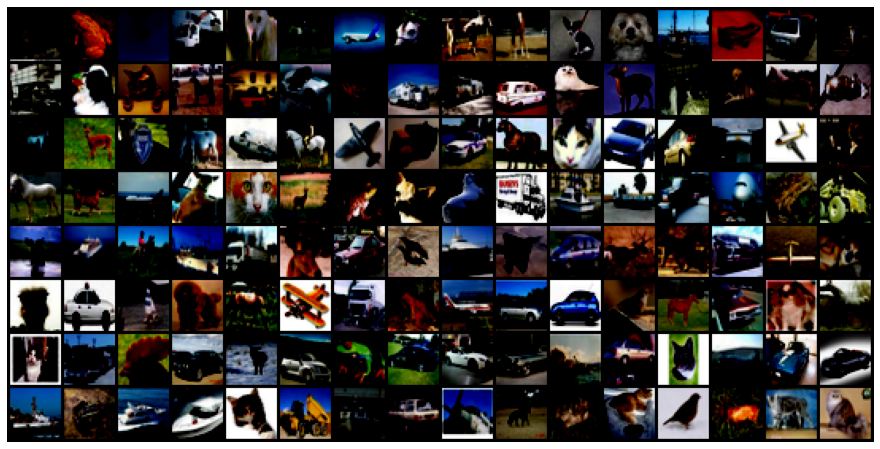

In [ ]:
from torchvision.utils import make_grid

for images, _ in trainloader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Building the network


In [ ]:
class ImageNetwork(nn.Module):
  def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
    ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''

    super().__init__()

    # Add the first layer, input to a hidden layer
    self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
    
    # Add a variable number of more hidden layers
    layer_size = zip(hidden_layers[:-1], hidden_layers[1:])
    self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in layer_size])
    

    # add the output
    self.output = nn.Linear(hidden_layers[-1], output_size)

    # dropout
    self.dropout = nn.Dropout(p=drop_p)
  
  def forward(self, x):
    ''' Forward pass through the network, returns the output logits '''
        
    # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
    for linear in self.hidden_layers:
      x = F.relu(linear(x))
      x = self.dropout(x)
    
    x = self.output(x)

    return F.log_softmax(x, dim=1)



# Train the network
Since the model's forward method returns the log-softmax, I used the negative log loss as my criterion, nn.NLLLoss(). I also chose to use the Adam optimizer. This is a variant of stochastic gradient descent which includes momentum and in general trains faster than basic SGD.

I've also included a block to measure the validation loss and accuracy. Since I'm using dropout in the network, I need to turn it off during inference. Otherwise, the network will appear to perform poorly because many of the connections are turned off. PyTorch allows to set a model in "training" or "evaluation" modes with model.train() and model.eval(), respectively. In training mode, dropout is turned on, while in evaluation mode, dropout is turned off. This effects other modules as well that should be on during training but off during inference.

The validation code consists of a forward pass through the validation set (also split into batches). With the log-softmax output, I calculate the loss on the validation set, as well as the prediction accuracy.

In [ ]:
input_size = 32 * 32
output_size = 10
hidden_layers = [516, 256, 64, 32]
drop_p=0.5

model = ImageNetwork(input_size, output_size, hidden_layers, drop_p=drop_p)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)

In [ ]:
# Use GPU if it's available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device);

In [ ]:
def validation(model, testloader, criterion):
  test_loss = 0
  accuracy = 0

  for images, labels in testloader:
    #images, labels = images.to(device), labels.to(device)
    images.resize_(images.size()[0], 32*32)
    output = model.forward(images)

    test_loss += criterion(output, labels).item()

    ps = torch.exp(output)
    ps.max(dim=1)

    equality = (labels.data == ps.max(dim=1)[1])
    accuracy += torch.mean(equality.type(torch.FloatTensor))
  
  return test_loss, accuracy

In [ ]:
epochs = 2
steps = 0
print_every = 40
running_loss = 0

for epoch in range(epochs):
  model.train()
  for images, labels in trainloader:
    steps += 1
    # Move input and label tensors to the default device
    #images, labels = images.to(device), labels.to(device)
    # Flatten images into a 32*32 long vector
    images.resize_(images.size()[0], 32*32)

    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/2..  Training Loss: 2.714..  Test Loss: 2.305..  Test Accuracy: 0.101
Epoch: 1/2..  Training Loss: 2.348..  Test Loss: 2.304..  Test Accuracy: 0.100
Epoch: 1/2..  Training Loss: 2.316..  Test Loss: 2.305..  Test Accuracy: 0.100
Epoch: 1/2..  Training Loss: 2.342..  Test Loss: 2.304..  Test Accuracy: 0.100
Epoch: 1/2..  Training Loss: 2.333..  Test Loss: 2.303..  Test Accuracy: 0.102
Epoch: 1/2..  Training Loss: 2.367..  Test Loss: 2.304..  Test Accuracy: 0.101
Epoch: 1/2..  Training Loss: 2.404..  Test Loss: 2.305..  Test Accuracy: 0.100
Epoch: 1/2..  Training Loss: 2.435..  Test Loss: 2.306..  Test Accuracy: 0.102
Epoch: 1/2..  Training Loss: 2.310..  Test Loss: 2.304..  Test Accuracy: 0.100
Epoch: 2/2..  Training Loss: 2.304..  Test Loss: 2.304..  Test Accuracy: 0.100
Epoch: 2/2..  Training Loss: 2.305..  Test Loss: 2.305..  Test Accuracy: 0.100
Epoch: 2/2..  Training Loss: 2.304..  Test Loss: 2.304..  Test Accuracy: 0.101
Epoch: 2/2..  Training Loss: 2.305..  Test Loss: 2.3

# Inference

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def classify(image, probs):
    ''' Function for viewing an image and it's predicted classes.
    '''
    probs = probs.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(32, 32, 1).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['airplane',
                         'automobile',
                         'bird',
                         'cat',
                         'deer',
                         'dog',
                         'frog',
                         'horse',
                         'ship',
                         'truck'], size='small')
    
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

TypeError: ignored

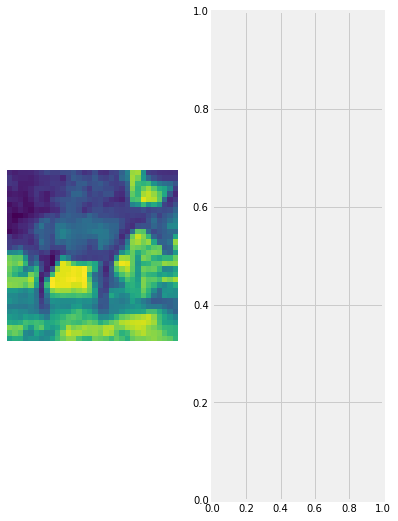

In [ ]:
model.eval()

dataiter = iter(testloader)

#images, labels = images.to(device), labels.to(device)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(3, 32*32)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
  #model.to(device);
  output = model.forward(img)

ps = torch.exp(output)

classify(img.view(3, 32,  32), ps)
# img[0].shape